In [1]:
import numpy as np
import pandas as pd
from malid import config, io, helpers
from malid.datamodels import healthy_label, GeneLocus, TargetObsColumnEnum
import genetools
from genetools.palette import HueValueStyle
import seaborn as sns

In [2]:
# Uses data from vgene_usage_stats.ipynb


def get_dirs(gene_locus: GeneLocus):
    output_dir = (
        config.paths.model_interpretations_for_selected_cross_validation_strategy_output_dir
        / gene_locus.name
    )
    highres_output_dir = (
        config.paths.high_res_outputs_dir_for_cross_validation_strategy
        / "model_interpretations"
        / gene_locus.name
    )

    return output_dir, highres_output_dir


def import_v_gene_counts(gene_locus: GeneLocus):
    output_dir, highres_output_dir = get_dirs(gene_locus)

    specimen_v_gene_counts_df = pd.read_csv(
        highres_output_dir / "v_gene_counts_by_specimen.tsv.gz", sep="\t"
    )

    # subselect to test folds only (which also excludes global fold -1), and set index
    specimen_v_gene_counts_df_test_only = specimen_v_gene_counts_df[
        specimen_v_gene_counts_df["fold_label"] == "test"
    ]

    # confirm only one entry per specimen now
    assert not specimen_v_gene_counts_df_test_only["specimen_label"].duplicated().any()
    specimen_v_gene_counts_df_test_only = specimen_v_gene_counts_df_test_only.set_index(
        "specimen_label"
    ).drop(["fold_id", "fold_label"], axis=1)

    # fill na
    specimen_v_gene_counts_df_test_only = specimen_v_gene_counts_df_test_only.fillna(0)

    v_gene_cols = specimen_v_gene_counts_df_test_only.columns
    v_gene_cols = v_gene_cols[~v_gene_cols.isin(["disease"])]

    # get filtered subset of v_gene_cols, produced previously
    v_gene_cols_filtered = pd.read_csv(output_dir / "meaningful_v_genes.txt")[
        "v_gene"
    ].values
    assert all(vgene in v_gene_cols for vgene in v_gene_cols_filtered)  # sanity check

    return specimen_v_gene_counts_df_test_only, v_gene_cols, v_gene_cols_filtered

In [3]:
totals = {}
for gene_locus in config.gene_loci_used:
    print(gene_locus)
    df, v_gene_cols, _ = import_v_gene_counts(gene_locus=gene_locus)
    totals[gene_locus.name] = df[v_gene_cols].sum(axis=1).astype(int)
totals = pd.DataFrame(totals).fillna(0).astype(int)
totals

GeneLocus.BCR
GeneLocus.TCR


,BCR,TCR
specimen_label,,
M111-S001,66859,30140
M111-S002,64150,64622
M111-S003,55595,66197
M111-S004,56519,45227
M111-S005,49314,42001
...,...,...
M64-110,43554,69449
M64-111,14042,32648
M64-112,21395,40730


In [4]:
# have some BCR only specimens, as expected
(totals == 0).any(axis=0)

BCR    False
TCR     True
dtype: bool

In [5]:
# have some BCR only specimens, as expected
totals.loc[(totals == 0).any(axis=1)]

,BCR,TCR
specimen_label,,
M281redo-S001,6633,0
M281redo-S002,5202,0
M281redo-S003,14356,0
M281redo-S004,10219,0
M281redo-S005,10701,0
...,...,...
M404-S002,56643,0
M404-S005,55613,0
M404-S008,68846,0


In [6]:
cols = totals.columns
cols

Index(['BCR', 'TCR'], dtype='object')

In [7]:
total = totals.sum(axis=1)
total

specimen_label
M111-S001     96999
M111-S002    128772
M111-S003    121792
M111-S004    101746
M111-S005     91315
              ...  
M64-110      113003
M64-111       46690
M64-112       62125
M64-113      217474
M64-114      221295
Length: 616, dtype: int64

In [8]:
orig_shape = totals.shape
totals = pd.merge(
    totals,
    helpers.get_all_specimen_info().set_index("specimen_label")[
        ["disease", "study_name", "participant_label", "in_training_set"]
    ],
    left_index=True,
    right_index=True,
    validate="1:1",
    how="inner",
)
assert totals.shape[0] == orig_shape[0]
totals

,BCR,TCR,disease,study_name,participant_label,in_training_set
specimen_label,,,,,,
M111-S001,66859,30140,HIV,HIV,BFI-0003462,True
M111-S002,64150,64622,HIV,HIV,BFI-0003481,True
M111-S003,55595,66197,HIV,HIV,BFI-0003466,True
M111-S004,56519,45227,HIV,HIV,BFI-0003460,True
M111-S005,49314,42001,HIV,HIV,BFI-0003463,True
...,...,...,...,...,...,...
M64-110,43554,69449,Healthy/Background,Healthy-StanfordBloodCenter,BFI-0003159,True
M64-111,14042,32648,Healthy/Background,Healthy-StanfordBloodCenter,BFI-0003160,True
M64-112,21395,40730,Healthy/Background,Healthy-StanfordBloodCenter,BFI-0003161,True


In [9]:
assert totals["in_training_set"].all(), "sanity check"

In [10]:
totals.to_csv(
    config.paths.base_output_dir_for_selected_cross_validation_strategy
    / "selected_clone_count_for_each_specimen.tsv",
    sep="\t",
)

In [11]:
# num clones
totals.groupby(["disease", "study_name"], observed=True)[cols].sum()

BCR  \
disease            study_name                                                    
Covid19            Covid19-Seattle                                      272976   
                   Covid19-Stanford                                     398786   
                   Covid19-buffycoat                                    254787   
HIV                HIV                                                 2724652   
Healthy/Background Diabetes biobank                                      31570   
                   HIV                                                  819477   
                   Healthy-StanfordBloodCenter                         3280013   
                   Healthy-StanfordBloodCenter_included-in-reseque...  1600818   
                   Lupus                                                359956   
                   New Lupus Paxgene                                    116330   
                   New Lupus RNA                                        124141   
                   healthy_children                                    1119054   
Influenza          Flu vaccine UPenn 2021                               844756   
Lupus              Lupus                                                511456   
                   Lupus Pediatric                                     2227096   
                   New Lupus Paxgene                                    283850   
                   New Lupus RNA                                        293688   
T1D                Diabetes biobank                                    1012509   

                                                                           TCR  
disease            study_name                                                   
Covid19            Covid19-Seattle                                           0  
                   Covid19-Stanford                                     653773  
                   Covid19-buffycoat                                    193501  
HIV                HIV                                                 3163861  
Healthy/Background Diabetes biobank                                      72700  
                   HIV                                                 1472102  
                   Healthy-StanfordBloodCenter                         4133857  
                   Healthy-StanfordBloodCenter_included-in-reseque...  2163296  
                   Lupus                                                     0  
                   New Lupus Paxgene                                    377708  
                   New Lupus RNA                                        107595  
                   healthy_children                                    3833792  
Influenza          Flu vaccine UPenn 2021                              1243631  
Lupus              Lupus                                                     0  
                   Lupus Pediatric                                     2362117  
                   New Lupus Paxgene                                    739929  
                   New Lupus RNA                                        520384  
T1D                Diabetes biobank                                    2468914

In [12]:
# num patients
totals.groupby(["disease", "study_name"], observed=True)[
    "participant_label"
].nunique().to_frame(name="number of individuals")

number of individuals
disease            study_name                                                               
Covid19            Covid19-Seattle                                                         5
                   Covid19-Stanford                                                       48
                   Covid19-buffycoat                                                      10
HIV                HIV                                                                    95
Healthy/Background Diabetes biobank                                                        3
                   HIV                                                                    43
                   Healthy-StanfordBloodCenter                                            72
                   Healthy-StanfordBloodCenter_included-in-reseque...                     30
                   Lupus                                                                  23
                   New Lupus Paxgene                                                       2
                   New Lupus RNA                                                           4
                   healthy_children                                                       43
Influenza          Flu vaccine UPenn 2021                                                 37
Lupus              Lupus                                                                  23
                   Lupus Pediatric                                                        43
                   New Lupus Paxgene                                                       5
                   New Lupus RNA                                                          15
T1D                Diabetes biobank                                                       92

In [13]:
# num specimens
totals.groupby(["disease", "study_name"], observed=True).size().to_frame(
    name="number of specimens"
)

number of specimens
disease            study_name                                                             
Covid19            Covid19-Seattle                                                       5
                   Covid19-Stanford                                                     48
                   Covid19-buffycoat                                                    10
HIV                HIV                                                                  98
Healthy/Background Diabetes biobank                                                      3
                   HIV                                                                  43
                   Healthy-StanfordBloodCenter                                          72
                   Healthy-StanfordBloodCenter_included-in-reseque...                   30
                   Lupus                                                                27
                   New Lupus Paxgene                                                     2
                   New Lupus RNA                                                         4
                   healthy_children                                                     43
Influenza          Flu vaccine UPenn 2021                                               37
Lupus              Lupus                                                                34
                   Lupus Pediatric                                                      43
                   New Lupus Paxgene                                                     5
                   New Lupus RNA                                                        16
T1D                Diabetes biobank                                                     96

In [14]:
# make a table of all
df_all = pd.concat(
    [
        # num patients
        totals.groupby(["disease", "study_name"], observed=True)["participant_label"]
        .nunique()
        .to_frame(name="number of individuals"),
        # num specimens
        totals.groupby(["disease", "study_name"], observed=True)
        .size()
        .to_frame(name="number of specimens"),
        # num clones
        totals.groupby(["disease", "study_name"], observed=True)[cols].sum(),
    ],
    axis=1,
)
df_all.to_csv(
    config.paths.base_output_dir_for_selected_cross_validation_strategy
    / "size_of_each_disease_batch.tsv",
    sep="\t",
)
df_all

number of individuals  \
disease            study_name                                                                  
Covid19            Covid19-Seattle                                                         5   
                   Covid19-Stanford                                                       48   
                   Covid19-buffycoat                                                      10   
HIV                HIV                                                                    95   
Healthy/Background Diabetes biobank                                                        3   
                   HIV                                                                    43   
                   Healthy-StanfordBloodCenter                                            72   
                   Healthy-StanfordBloodCenter_included-in-reseque...                     30   
                   Lupus                                                                  23   
                   New Lupus Paxgene                                                       2   
                   New Lupus RNA                                                           4   
                   healthy_children                                                       43   
Influenza          Flu vaccine UPenn 2021                                                 37   
Lupus              Lupus                                                                  23   
                   Lupus Pediatric                                                        43   
                   New Lupus Paxgene                                                       5   
                   New Lupus RNA                                                          15   
T1D                Diabetes biobank                                                       92   

                                                                       number of specimens  \
disease            study_name                                                                
Covid19            Covid19-Seattle                                                       5   
                   Covid19-Stanford                                                     48   
                   Covid19-buffycoat                                                    10   
HIV                HIV                                                                  98   
Healthy/Background Diabetes biobank                                                      3   
                   HIV                                                                  43   
                   Healthy-StanfordBloodCenter                                          72   
                   Healthy-StanfordBloodCenter_included-in-reseque...                   30   
                   Lupus                                                                27   
                   New Lupus Paxgene                                                     2   
                   New Lupus RNA                                                         4   
                   healthy_children                                                     43   
Influenza          Flu vaccine UPenn 2021                                               37   
Lupus              Lupus                                                                34   
                   Lupus Pediatric                                                      43   
                   New Lupus Paxgene                                                     5   
                   New Lupus RNA                                                        16   
T1D                Diabetes biobank                                                     96   

                                                                           BCR  \
disease            study_name                                                    
Covid19            Covid19-Seattle                                      272976   
                   Covi

# Sanity checks

In [15]:
def import_cdr3_length_counts(gene_locus: GeneLocus):
    output_dir, highres_output_dir = get_dirs(gene_locus)

    specimen_cdr3_length_counts_df = pd.read_csv(
        highres_output_dir / "cdr3_length_counts_by_specimen.tsv.gz", sep="\t"
    )

    # subselect to test folds only (which also excludes global fold -1), and set index
    specimen_cdr3_length_counts_df_test_only = specimen_cdr3_length_counts_df[
        specimen_cdr3_length_counts_df["fold_label"] == "test"
    ]

    # confirm only one entry per specimen now
    assert (
        not specimen_cdr3_length_counts_df_test_only["specimen_label"]
        .duplicated()
        .any()
    )
    specimen_cdr3_length_counts_df_test_only = (
        specimen_cdr3_length_counts_df_test_only.set_index("specimen_label").drop(
            ["fold_id", "fold_label"], axis=1
        )
    )

    # drop any columns that are all N/A
    specimen_cdr3_length_counts_df_test_only = (
        specimen_cdr3_length_counts_df_test_only.dropna(axis=1, how="all")
    )

    # fill remaining N/As with 0
    specimen_cdr3_length_counts_df_test_only = (
        specimen_cdr3_length_counts_df_test_only.fillna(0)
    )

    cdr3_length_cols = specimen_cdr3_length_counts_df_test_only.columns
    cdr3_length_cols = cdr3_length_cols[~cdr3_length_cols.isin(["disease"])]

    # Convert cols to ints
    specimen_cdr3_length_counts_df_test_only.rename(
        columns={i: int(i) for i in cdr3_length_cols}, inplace=True
    )
    # Get latest column list
    cdr3_length_cols = specimen_cdr3_length_counts_df_test_only.columns
    cdr3_length_cols = cdr3_length_cols[~cdr3_length_cols.isin(["disease"])]

    # Fill in skips as all 0s
    for cdr3_len in np.arange(min(cdr3_length_cols), max(cdr3_length_cols)):
        if cdr3_len not in cdr3_length_cols:
            specimen_cdr3_length_counts_df_test_only[cdr3_len] = 0.0

    # Get latest column list
    cdr3_length_cols = specimen_cdr3_length_counts_df_test_only.columns
    cdr3_length_cols = cdr3_length_cols[~cdr3_length_cols.isin(["disease"])]

    return specimen_cdr3_length_counts_df_test_only, cdr3_length_cols

In [16]:
if GeneLocus.BCR in config.gene_loci_used:
    df, v_gene_cols, _ = import_v_gene_counts(gene_locus=GeneLocus.BCR)
    total = df[v_gene_cols].sum(axis=1).astype(int)
    print(total)

specimen_label
M111-S003    55595
M111-S007    34928
M111-S009    42548
M111-S011    28308
M111-S016    32746
             ...  
M64-094       5250
M64-095       9274
M64-099      94233
M64-100      70685
M64-108      57926
Length: 616, dtype: int64


In [17]:
if GeneLocus.BCR in config.gene_loci_used:
    df, v_gene_cols = import_cdr3_length_counts(gene_locus=GeneLocus.BCR)
    total2 = df[v_gene_cols].sum(axis=1).astype(int)
    print(total2)
    assert (total == total2).all()

specimen_label
M111-S003    55595
M111-S007    34928
M111-S009    42548
M111-S011    28308
M111-S016    32746
             ...  
M64-094       5250
M64-095       9274
M64-099      94233
M64-100      70685
M64-108      57926
Length: 616, dtype: int64


In [18]:
if GeneLocus.BCR in config.gene_loci_used:
    specimen_isotype_counts_df = pd.read_csv(
        config.paths.dataset_specific_metadata_for_selected_cross_validation_strategy
        / "isotype_counts_by_specimen.tsv",
        sep="\t",
    )
    specimen_isotype_counts_df = specimen_isotype_counts_df[
        specimen_isotype_counts_df["fold_label"] == "test"
    ]
    assert not specimen_isotype_counts_df["specimen_label"].duplicated().any()
    specimen_isotype_counts_df = specimen_isotype_counts_df.set_index("specimen_label")[
        ["IGHD-M", "IGHA", "IGHG"]
    ]
    total3 = specimen_isotype_counts_df.sum(axis=1)
    print(total3)

    print(set(total.index).symmetric_difference(set(total3.index)))

    assert (total == total3.loc[total.index]).all()

specimen_label
M111-S003    55595
M111-S007    34928
M111-S009    42548
M111-S011    28308
M111-S016    32746
             ...  
M64-094       5250
M64-095       9274
M64-099      94233
M64-100      70685
M64-108      57926
Length: 616, dtype: int64
set()


In [19]:
if GeneLocus.TCR in config.gene_loci_used:
    df, v_gene_cols, _ = import_v_gene_counts(gene_locus=GeneLocus.TCR)
    total = df[v_gene_cols].sum(axis=1)
    print(total)

specimen_label
M111-S003    66197.0
M111-S007    28358.0
M111-S009    94828.0
M111-S011    49699.0
M111-S016    32839.0
              ...   
M64-094       2692.0
M64-095      12281.0
M64-099      56479.0
M64-100      42089.0
M64-108      91222.0
Length: 550, dtype: float64


In [20]:
if GeneLocus.TCR in config.gene_loci_used:
    df, v_gene_cols = import_cdr3_length_counts(gene_locus=GeneLocus.TCR)
    total2 = df[v_gene_cols].sum(axis=1)
    print(total2)
    assert (total == total2).all()

specimen_label
M111-S003    66197.0
M111-S007    28358.0
M111-S009    94828.0
M111-S011    49699.0
M111-S016    32839.0
              ...   
M64-094       2692.0
M64-095      12281.0
M64-099      56479.0
M64-100      42089.0
M64-108      91222.0
Length: 550, dtype: float64


# Plot

In [21]:
# Create "available loci" column
totals_annot = pd.concat(
    [
        totals,
        totals.apply(
            lambda row: (["BCR"] if "BCR" in row and row["BCR"] > 0 else [])
            + (["TCR"] if "TCR" in row and row["TCR"] > 0 else []),
            axis=1,
        ).rename("Available loci"),
    ],
    axis=1,
)
totals_annot["Available loci"] = totals_annot["Available loci"].str.join(" + ")
totals_annot

,BCR,TCR,disease,study_name,participant_label,in_training_set,Available loci
specimen_label,,,,,,,
M111-S001,66859,30140,HIV,HIV,BFI-0003462,True,BCR + TCR
M111-S002,64150,64622,HIV,HIV,BFI-0003481,True,BCR + TCR
M111-S003,55595,66197,HIV,HIV,BFI-0003466,True,BCR + TCR
M111-S004,56519,45227,HIV,HIV,BFI-0003460,True,BCR + TCR
M111-S005,49314,42001,HIV,HIV,BFI-0003463,True,BCR + TCR
...,...,...,...,...,...,...,...
M64-110,43554,69449,Healthy/Background,Healthy-StanfordBloodCenter,BFI-0003159,True,BCR + TCR
M64-111,14042,32648,Healthy/Background,Healthy-StanfordBloodCenter,BFI-0003160,True,BCR + TCR
M64-112,21395,40730,Healthy/Background,Healthy-StanfordBloodCenter,BFI-0003161,True,BCR + TCR


In [22]:
assert totals_annot["in_training_set"].all()

In [23]:
# same values across all rows for each person
assert (
    totals_annot.groupby("participant_label")["Available loci"].nunique() == 1
).all()

In [24]:
totals_annot_dedupe_by_participant = totals_annot.groupby("participant_label").head(n=1)
totals_annot_dedupe_by_participant

,BCR,TCR,disease,study_name,participant_label,in_training_set,Available loci
specimen_label,,,,,,,
M111-S001,66859,30140,HIV,HIV,BFI-0003462,True,BCR + TCR
M111-S002,64150,64622,HIV,HIV,BFI-0003481,True,BCR + TCR
M111-S003,55595,66197,HIV,HIV,BFI-0003466,True,BCR + TCR
M111-S004,56519,45227,HIV,HIV,BFI-0003460,True,BCR + TCR
M111-S005,49314,42001,HIV,HIV,BFI-0003463,True,BCR + TCR
...,...,...,...,...,...,...,...
M64-110,43554,69449,Healthy/Background,Healthy-StanfordBloodCenter,BFI-0003159,True,BCR + TCR
M64-111,14042,32648,Healthy/Background,Healthy-StanfordBloodCenter,BFI-0003160,True,BCR + TCR
M64-112,21395,40730,Healthy/Background,Healthy-StanfordBloodCenter,BFI-0003161,True,BCR + TCR


{"message": "'created' timestamp seems very low; regarding as unix timestamp", "time": "2024-08-09T22:21:15.259529"}


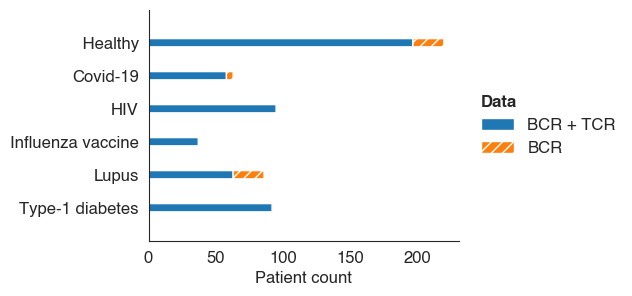

In [25]:
fig, ax = genetools.plots.stacked_bar_plot(
    totals_annot_dedupe_by_participant.assign(
        disease=totals_annot_dedupe_by_participant["disease"].replace(
            {
                # Friendlier names:
                "Influenza": "Influenza vaccine",
                "T1D": "Type-1 diabetes",
                # Note there's a space character in front of Healthy to force it to be first in sort order
                "Healthy/Background": " Healthy",
                "Covid19": "Covid-19",
            }
        )
    ),
    index_key="disease",
    hue_key="Available loci",
    palette={
        "BCR + TCR": HueValueStyle(color=sns.color_palette()[0]),
        "BCR": HueValueStyle(color=sns.color_palette()[1], hatch="///"),
        "TCR": HueValueStyle(color=sns.color_palette()[2], hatch="..."),
    },
    figsize=(4, 3),
    # ax=ax,
    normalize=False,
    vertical=False,
    hue_order=[
        x
        for x in ["BCR + TCR", "BCR", "TCR"]
        if x in totals_annot_dedupe_by_participant["Available loci"].unique()
    ],
    axis_label="Patient count",
    legend_title="Data",
    enable_legend=True,
)
genetools.plots.savefig(
    fig,
    config.paths.base_output_dir_for_selected_cross_validation_strategy
    / "number_of_patients_by_disease.png",
    dpi=300,
)
genetools.plots.savefig(
    fig,
    config.paths.base_output_dir_for_selected_cross_validation_strategy
    / "number_of_patients_by_disease.pdf",
)

In [26]:
# Spot check against:
totals_annot.groupby("disease")["Available loci"].value_counts()

disease             Available loci
Covid19             BCR + TCR          58
                    BCR                 5
HIV                 BCR + TCR          98
Healthy/Background  BCR + TCR         197
                    BCR                27
Influenza           BCR + TCR          37
Lupus               BCR + TCR          64
                    BCR                34
T1D                 BCR + TCR          96
Name: Available loci, dtype: int64

In [27]:
# Spot check against:
totals_annot.groupby("disease").size()

disease
Covid19                63
HIV                    98
Healthy/Background    224
Influenza              37
Lupus                  98
T1D                    96
dtype: int64